In [1]:
import pandas as pd
import numpy as np 
import glob
import os 
import re
import pickle
from clustereval import stability, purity
import plotnine as pn
import operator
import functools
os.chdir('/data/swamyvs/scEiad_subcelltype')

In [2]:
## load data 
with open("testing/exp_purity_df_list_full_try3.pck", 'rb') as ofl:
    all_purity_calcs= pickle.load(ofl)
exp_files = glob.glob("clustering_out/*/*.csv.gz", recursive=True)
exp_meta_df = pd.DataFrame([re.split("_|-|/", x.split('out/')[1])[::2] for x in exp_files],
                           columns=['clustering_type', 'experiment', 'dist', 'knn']).assign(path=exp_files)
exp_dfs = [pd.read_csv(i).assign(
    labels=lambda x: 'clu_' + x.labels.astype(str)) for i in exp_files]

sanes_lab_df = pd.read_csv('testing/sanes_bc_lab.csv')
exp_cluster_sets = [dict(purity.df2DictSets(df)) for df in exp_dfs]
sanes_cluster_sets = purity.df2DictSets(sanes_lab_df)

sanes_purity_scores = purity.run_purity_calc(
    (sanes_cluster_sets, exp_cluster_sets, 'sanes_cstr'))

## per barcode purity 
reduction = pd.read_csv('testing/amacrin_mm_scvi_dim.csv', index_col=0)
all_bc = pd.DataFrame({'Barcode' : reduction.index.to_list()})
exp_meta_df_exp_raw = exp_meta_df[['clustering_type', 'experiment', 'dist', 'knn']].agg('-'.join, axis=1).to_list()

tup_dfs = list(zip(exp_meta_df_exp_raw, exp_dfs))
tup_dfs.sort(key=operator.itemgetter(0))

purity_tup_dfs = [(df.columns[2], df) for df in all_purity_calcs]
purity_tup_dfs.sort(key=operator.itemgetter(0))

def pjoin(left, right, full_df):
    expname = right.columns[2]
    right.columns = [expname, 'n_exp_evaluated', 'labels']
    left = left.merge(full_df, how = 'outer')
    res = left.merge(right, how='left', on='labels').drop(columns= ['labels','n_exp_evaluated']).sort_values('Barcode').reset_index(drop=True)[expname]
    return(res)

#
k = [pjoin(tup_dfs[i][1].copy(), purity_tup_dfs[i][1].copy(), all_bc) for i in range(len(tup_dfs))]


#%%
res = pd.concat(k, axis=1, ignore_index=True)
#%%
avg_per_cell_purity = pd.DataFrame({'Barcode': all_bc.sort_values('Barcode')['Barcode'].to_list(), 
                'avg_purity': res.mean(axis=1, skipna = True).to_numpy() })


clu_size_dfs =  [ df.groupby('labels').count().reset_index(drop = False) for df in exp_dfs]
clu_size_dfs = list(zip(exp_meta_df_exp_raw, clu_size_dfs))
clu_size_dfs.sort(key = operator.itemgetter(0))

purity_summary = [(df.columns[2],  df.purity.mean(),df.purity.median(), df.n_exp_evaluated.mean(), df.iloc[:,2].nunique() ) for df in  all_purity_calcs]
purity_summary_df = pd.DataFrame(purity_summary, columns=['raw', 'avg_purity', 'median_purity', 'avg_exp_run','ncluster'])
purity_summary_df[['alg', 'exp', 'res', 'knn']] = purity_summary_df.raw.str.split('-', expand = True)

In [7]:

def cnjoin(left, right):
    expname = right.columns[2].split('-')
    right.columns = ['purity', 'n_exp_evaluated', 'labels']
    res = left.merge(right, how='inner', on='labels')[['Barcode','purity']].assign(alg = expname[0],
           dist = expname[2],
           knn = expname[3]
           )
    return(res)


k = [cnjoin(clu_size_dfs[i][1].copy(), purity_tup_dfs[i][1].copy()) for i in range(len(clu_size_dfs)) ]
purity_by_cluster_size = pd.concat(k, axis = 0, ignore_index=True)


Overview of the "Purity metric"

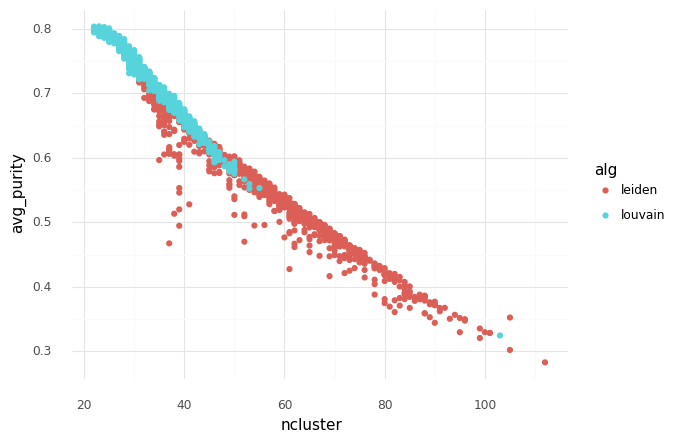

<ggplot: (2932136789242)>

In [3]:
(
    pn.ggplot(purity_summary_df) + 
    pn.geom_point(pn.aes(x='ncluster', y='avg_purity', color = 'alg')) +
    pn.theme_minimal()
)

Purity fairly correlated with number of clusters

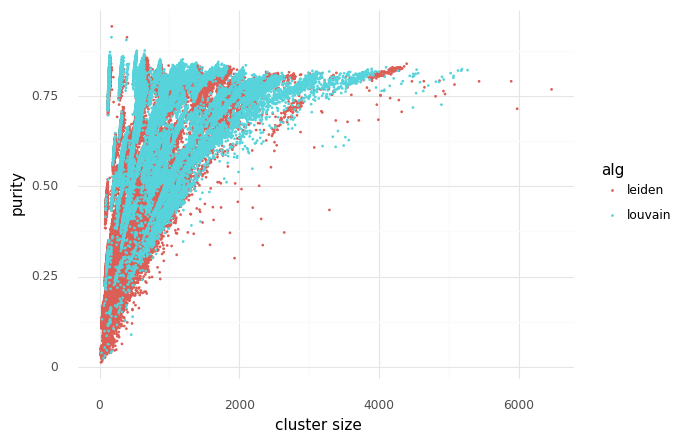

<ggplot: (2932788395183)>

In [11]:
(
    pn.ggplot(purity_by_cluster_size) + 
    pn.geom_point(pn.aes(x='Barcode', y='purity', color ='alg'),size = .1 ) + 
    pn.xlab('cluster size') +
    pn.theme_minimal()
)

higher cluster size generally leads to higher purity, but a low cluster size does not necessarily mean  low purity

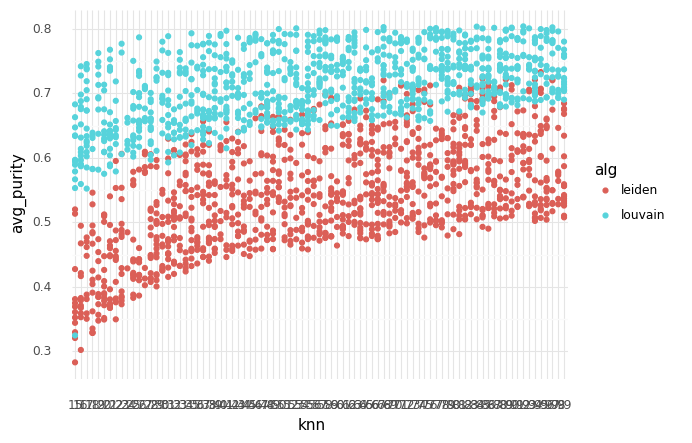

<ggplot: (2932787750741)>

In [12]:
(
    pn.ggplot(purity_summary_df) + 
    pn.geom_point(pn.aes(x='knn', y='avg_purity', color = 'alg')) +
    pn.theme_minimal()
)

A higher value of k for nn search generally leads to more pure clusters

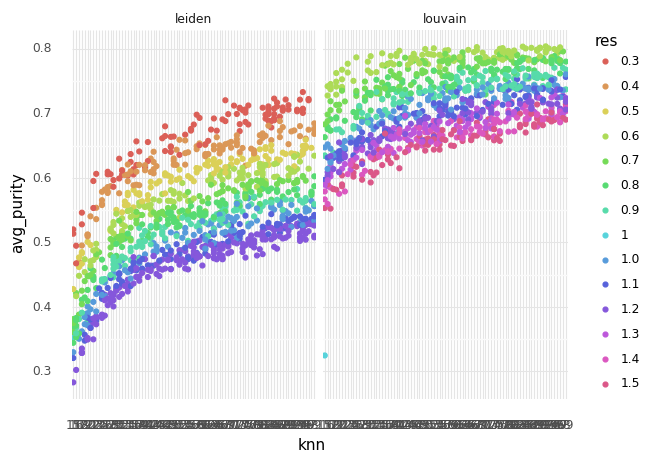

<ggplot: (2932787948719)>

In [15]:
(
    pn.ggplot(purity_summary_df) +
    pn.geom_point(pn.aes(x='knn', y='avg_purity', color='res')) +
    pn.facet_wrap('alg')+
    pn.theme_minimal()
)

This jives with what we saw with cluster size vs purity, as higher resolution > more clusters > lower purity